In [ ]:
import numpy as np
import pandas as pd

# Training a Gradient Boost Model

Checking if everything loads well. Change input path and number of variables!

In [3]:
df = pd.read_pickle('./experiments/wizard_nfsp_result/trick_prediction_results/tp01.pickle')
N_VARIABLES = 60 # Change this value dependant on the dataset


# df1 = pd.read_pickle('C:/Users/Magnus/Documents/GitHub/rlcard/experiments/wizard_nfsp_result/trick_prediction_results/tp02.pickle')
# df=pd.concat((df,df1))
# df.set_index(list(np.arange(0,N_VARIABLES))).groupby(list(np.arange(0,24))).mean()
df2=df.set_index(list(np.arange(0,N_VARIABLES)))
df2

60
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59    
0 0 0 0 0 0 0 0 0 0 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0    3
      1 0 0 0 0 0 0 0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    2
      0 1 0 0 0 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0    2
        0 0 0 0 0 1 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    3
                  0 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0    2
...                                                                                                                                                                        ..
                       0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0    1
      1 0 0 0 1 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0    1
      0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0    4
      1 0 0 0 1 0 0 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0    2
      0 0 0 0 0 0 0 0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0    3

[800000 rows x 1 columns]

Training the model.

In [10]:
import xgboost as xgb
data=df
sz=data.shape

### Train-Test Split
train = data.loc[:int(sz[0] * 0.7), :]
test = data.loc[int(sz[0] * 0.3):, :]

train_X = train.loc[:, :N_VARIABLES-1]
train_Y = train.loc[:, N_VARIABLES]

test_X = test.loc[:, :N_VARIABLES-1]
test_Y = test.loc[:, N_VARIABLES]

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['nthread'] = 4
param['num_class'] = 6

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 50
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# # do the same thing again, but output probabilities
# param['objective'] = 'multi:softprob'
# bst = xgb.train(param, xg_train, num_round, watchlist)
# # Note: this convention has been changed since xgboost-unity
# # get prediction, this is in 1D array, need reshape to (ndata, nclass)
# pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 6)
# pred_label = np.argmax(pred_prob, axis=1)
# error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
# print('Test error using softprob = {}'.format(error_rate))

[21:32:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.76892	test-mlogloss:1.76927
[1]	train-mlogloss:1.74890	test-mlogloss:1.74952
[2]	train-mlogloss:1.73074	test-mlogloss:1.73165
[3]	train-mlogloss:1.71457	test-mlogloss:1.71575
[4]	train-mlogloss:1.69961	test-mlogloss:1.70103
[5]	train-mlogloss:1.68614	test-mlogloss:1.68780
[6]	train-mlogloss:1.67383	test-mlogloss:1.67570
[7]	train-mlogloss:1.66247	test-mlogloss:1.66455
[8]	train-mlogloss:1.65196	test-mlogloss:1.65425
[9]	train-mlogloss:1.64217	test-mlogloss:1.64462
[10]	train-mlogloss:1.63302	test-mlogloss:1.63567
[11]	train-mlogloss:1.62456	test-mlogloss:1.62737
[12]	train-mlogloss:1.61661	test-mlogloss:1.61958
[13]	train-mlogloss:1.60917	test-mlogloss:1.61232


Potentially further training.

In [114]:
# bst2=xgb.train(param, xg_train, 50, watchlist,xgb_model=bst2)

[0]	train-mlogloss:1.21898	test-mlogloss:1.24526
[1]	train-mlogloss:1.21803	test-mlogloss:1.24458
[2]	train-mlogloss:1.21697	test-mlogloss:1.24385
[3]	train-mlogloss:1.21619	test-mlogloss:1.24333
[4]	train-mlogloss:1.21542	test-mlogloss:1.24280
[5]	train-mlogloss:1.21457	test-mlogloss:1.24223
[6]	train-mlogloss:1.21385	test-mlogloss:1.24177
[7]	train-mlogloss:1.21288	test-mlogloss:1.24109
[8]	train-mlogloss:1.21201	test-mlogloss:1.24049
[9]	train-mlogloss:1.21116	test-mlogloss:1.23993
[10]	train-mlogloss:1.21016	test-mlogloss:1.23924
[11]	train-mlogloss:1.20933	test-mlogloss:1.23868
[12]	train-mlogloss:1.20852	test-mlogloss:1.23815
[13]	train-mlogloss:1.20754	test-mlogloss:1.23748
[14]	train-mlogloss:1.20673	test-mlogloss:1.23694
[15]	train-mlogloss:1.20588	test-mlogloss:1.23639
[16]	train-mlogloss:1.20497	test-mlogloss:1.23576
[17]	train-mlogloss:1.20416	test-mlogloss:1.23521
[18]	train-mlogloss:1.20339	test-mlogloss:1.23468
[19]	train-mlogloss:1.20264	test-mlogloss:1.23418
[20]	train

# Testing & Saving
Here we have a look if the classifier actually works with a pre-set hand from the game which should result in almost 100% Win_Rate but mistakes are possible.

In [16]:
test_series1 = pd.DataFrame(np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]))
print(bst.predict(xgb.DMatrix(test_series1)))
# np.mean(df2.loc[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,:])

[5.]


In [17]:
bst.save_model('./rlcard/games/wizard_trickpreds/xgb_models/2P5C.json')

### Loading

In [72]:
model_xgb_2 = xgb.Booster()
model_xgb_2.load_model(r"./experiments/rlcard/games/wizard_ms_trickpreds/xgb_models/2P5C.json")

## log Plotting

In [8]:
import os
os.listdir("experiments/")

['newtest',
 'wizard_most_simple_nfsp_result',
 'wizard_ms_trickpreds_result_dqn',
 'wizard_ms_trickpreds_result_nfsp',
 'wizard_nfsp_result',
 'wizard_simple_nfsp_result',
 'wizard_s_trickpreds_result_nfsp',
 'wizard_trickpreds']

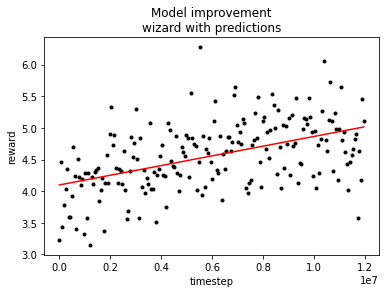

In [20]:
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

PATH = 'experiments/'+'wizard_trickpreds'+'/'
with open(PATH+"complete_log.txt") as f:
    lines = f.readlines()

timesteps = []
rewards = []
for line in lines:
    x=re.match("^\s+timestep\s+\|\s+([0-9]*)\\n$",line)
    if x:
        timesteps.append(int(x.group(1)))
    x=re.match("^\s+reward\s+\|\s+([0-9]+\.[0-9]+)\\n$",line)
    if x:
        rewards.append(float(x.group(1)))
    x=re.match("^\s+timestep\s+\|\s+([0-9]*)\\n$",line)

timesteps_transformed = []
last_timestep=0
add_timestep=0
for idx,timestep in enumerate(timesteps):
    if idx==0:
        add_timestep=0
    elif timestep==10:
        add_timestep=last_timestep
    # print(timestep,add_timestep)
    timesteps_transformed.append(timestep+add_timestep)
    last_timestep=timestep+add_timestep

# #Linear Model
reg = linear_model.LinearRegression()
reg.fit(np.array(timesteps_transformed).reshape(-1, 1),rewards)
fig, ax = plt.subplots(1)
ax.plot(timesteps_transformed,rewards, ".",color="black")
ax.plot(timesteps_transformed,timesteps_transformed*reg.coef_+reg.intercept_,"-",color="red")
ax.set_title("Model improvement\nwizard with predictions")
ax.set_xlabel("timestep")
ax.set_ylabel("reward")
plt.savefig(PATH+"model_improvement.png",facecolor="white")

# # Logarithmic model
# reg = linear_model.LinearRegression()
# inputs=np.array(list(zip(timesteps_transformed,np.log(timesteps_transformed))))

# reg.fit(inputs,np.array(rewards).reshape(len(rewards), 1))
# fig, ax = plt.subplots(1)
# ax.plot(timesteps_transformed,np.array(rewards).reshape(len(rewards), 1), ".")
# ax.plot(timesteps_transformed,np.sum(inputs*reg.coef_,axis=1)+reg.intercept_,"-",color="red")
# ax.set_title("Model improvement\nwizard most simple with trick predictions")
# ax.set_xlabel("timestep")
# ax.set_ylabel("reward")
# plt.savefig(PATH+"model_improvement.png")

### Helper & Misc cells

In [ ]:
r"C:\Users\Magnus\Documents\GitHub\rlcard\rlcard\games\wizard_s_trickpreds\xgb_models\2P5C.json".replace("\\","/")